# DiagDynCSW_proj_white

compute CSW terms for diagnosing the output from a numerical simulation

* compute slow stratif for modes smoothing in space
* first compute mean strat, then modes, then project modes, then dynamical terms of the CSW equations (see corresponding PDF)
* for now, take only 3 consecutives y-z sections from his files (for computing gradients)
* **Warning**: grid does not have the metrics, so using interp, integrate, diff may cause errors (unless you specify the grid cell sizes for the last two operations)

Adapted to white run !

Cf. LaTeX document "CSW_DynDiag.tex" (overleaf project InTideModelling)

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr
import crocosi.postp as pp
from crocosi.gridop import get_z, N2Profile
import crocosi.gridop as gp
from crocosi.vmodes import get_vmodes

/home1/datahome/nlahaye/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(dashboard_address=':8787')
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:36649 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


## Load simulation

In [3]:
root_path = '/home/datawork-lops-osi/equinox/jetn/'
run = 'jet_cfg1_wp0_noperturb_0a100j_floats_lev50_itide/'

gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
grav = 9.81
r = pp.CROCOrun(root_path+run, prefix='file_', open_nc=[], grid_params=gparams, verbose=True)

r['his']

Analysing directory /home/datawork-lops-osi/equinox/jetn/jet_cfg1_wp0_noperturb_0a100j_floats_lev50_itide/
Found 1 segments
Found 5 his files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected y_itide = 400000.0 m
Detected jet_ywidth = 800000.0 m
Detected jet_weight = 0.0
Detected omega = 0.000145444104333 1/s
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['his']
Grid size: (L ,M, N) = (258, 722, 50)


<xarray.Dataset>
Dimensions:              (axis_nbounds: 2, s_rho: 50, s_w: 51, time: 5, x_rho: 258, x_u: 257, y_rho: 722, y_v: 721)
Coordinates:
    eta_u                (y_rho, x_u) float32 dask.array<chunksize=(722, 257), meta=np.ndarray>
    eta_rho              (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    eta_v                (y_v, x_rho) float32 dask.array<chunksize=(721, 258), meta=np.ndarray>
    xi_u                 (y_rho, x_u) float32 dask.array<chunksize=(722, 257), meta=np.ndarray>
    xi_v                 (y_v, x_rho) float32 dask.array<chunksize=(721, 258), meta=np.ndarray>
    xi_rho               (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
  * s_rho                (s_rho) float32 -0.99 -0.97 -0.95 ... -0.05 -0.03 -0.01
    time_instant         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_counter         (time) float64 20.0 40.0 60.0 80.0 100.0
    f                    (y_rho, x_rho) flo

## Extract data on a y-z section and at a given time
Here we assume the mean state is given by the average over a single time window, hence no need to re-interpolate fields on a "mean grid"

In [4]:
indt = 0
Nx = r['his'].x_rho.size
indx = slice(Nx//2-1, Nx//2+2)
indu = slice(Nx//2-1, Nx//2+1)
ds = r['his'].isel(time=indt, x_rho=indx, x_u=indu).persist()
### compute dx and dy, assuming cartesian, regular grid
dx = np.diff(ds.xi_rho.isel(y_rho=0).values)[0]
dy = np.diff(ds.eta_rho.isel(x_rho=1, y_rho=slice(0,2)).values)[0]
# ds

## First, a few useful functions

In [5]:
### this should be in gridop 

def zi_w2rho(data, z_w, z_r):
    """ interpolate linearly from z_w grid to z_r grid
    warning: this version uses grid (xgcm)
    N.B.: z_r, z_w can the grid at any time or at rest (zeta=0) """
    dzr = grid.diff(z_w, "s") #.diff("s_w")
    idn, iup = slice(0,-1), slice(1,None)
    rna = {"s_w":"s_rho"}
    w1 = (z_w.isel(s_w=iup).rename(rna) - z_r)/dzr
    w2 = (z_r - z_w.isel(s_w=idn).rename(rna))/dzr
    w_i = (w1*data.isel(s_w=idn).rename(rna) + w2*data.isel(s_w=iup).rename(rna))
    return w_i.assign_coords(z_r=z_r)

def interp2z_3d(z0, z, v, b_extrap=2, t_extrap=2):
    """
    b_extrap, t_extrap:
        0 set to NaN
        1 set to nearest neighboor
        2 linear extrapolation
    """
    import crocosi.fast_interp3D as fi  # OpenMP accelerated C based interpolator
    # check v and z have identical shape
    assert v.ndim==z.ndim
    # add dimensions if necessary
    if v.ndim == 1:
        lv = v.squeeze()[:,None,None]
        lz = z.squeeze()[:,None,None]
    elif v.ndim == 2:
        lv = v[...,None]
        lz = z[...,None]
    else:
        lz = z[...]
        lv = v[...]
    #
    return fi.interp(z0.astype('float64'), lz.astype('float64'), lv.astype('float64'), 
                     b_extrap, t_extrap).squeeze()

def interp2z(z0, z, v, b_extrap, t_extrap):
    ''' interpolate vertically
    '''
    # check v and z have identical shape
    assert v.ndim==z.ndim
    # test if temporal dimension is present
    if v.ndim == 4:
        vi = [interp2z_3d(z0, z[...,t], v[...,t], b_extrap, t_extrap)[...,None] 
                  for t in range(v.shape[-1])]
        return np.concatenate(vi, axis=0) # (50, 722, 258, 1)
        #return v*0 + v.shape[3]
    else:
        return interp2z_3d(z0, z, v, b_extrap, t_extrap)
    
def interp_coredim(z0, z, v, b_extrap, t_extrap):
    ''' interpolate vertically
    when using core_dims=..., the core dims are moved to last axis
    here I transpose the fields to overcome this
    .not robust. can't plot field for instance, because 
    error "replacement data must match the Variable's shape"
    '''
    # check v and z have identical shape
    assert v.ndim==z.ndim
    # test if temporal dimension is present
    if v.ndim == 4: # ! WARNING not tested !!!
        vi = [interp2z_3d(z0.T, z[...,t,:].T, v[...,t,:].T, b_extrap, t_extrap)[...,None] 
                  for t in range(v.shape[-1])]
        return np.concatenate(vi, axis=0) # (50, 722, 258, 1)
        #return v*0 + v.shape[3]
    else:
        return interp2z_3d(z0.T, z.T, v.T, b_extrap, t_extrap) # transpose

In [6]:
### compute mean profile

siz_moy = Nx
indxm = slice(Nx//2-siz_moy//2,Nx//2+siz_moy//2+1)
indum = slice(Nx//2-siz_moy//2,Nx//2+siz_moy//2)

dsm = r['his'].isel(time=indt, x_rho=indxm, x_u=indum).persist()

### WARNING this works only for flat topo along x
sshm = dsm.ssh_a.mean("x_rho")
zmoy = get_z(r, zeta=sshm, h=dsm.h.isel(x_rho=siz_moy//2), vgrid='r', hgrid='r').persist()
zwoy = get_z(r, zeta=sshm, h=dsm.h.isel(x_rho=siz_moy//2), vgrid='w', hgrid='r').persist()

def z2zmoy(data, zz, zmoy=zmoy):
    # if not re-chunking, nanny restarts worker
    if "s_rho" in data.dims: data = data.chunk({"s_rho":-1})
    elif "s_w" in data.dims: data = data.chunk({"s_w":-1}) # this won't work, cf z2zwoy
    prov = xr.apply_ufunc(interp2z, zmoy, zz, data, 2, 2,
                    dask='parallelized', output_dtypes=[np.float64])
    return prov.assign_coords(z_rho=zmoy)

def z2zwoy(data, zz, zmoy=zwoy):
    # if not re-chunking, nanny restarts worker
    # to avoid broadcasting when interpolating from rho to w, need to specify core dims
    if "s_rho" in data.dims: 
        prov = xr.apply_ufunc(interp_coredim, zmoy.chunk({"s_w":-1}), zz.chunk({"s_rho":-1}), \
                          data.chunk({"s_rho":-1}), 2, 2, \
                    dask='parallelized', output_dtypes=[np.float64], \
                         input_core_dims=[["s_w"],["s_rho"],["s_rho"],[],[]], \
                         output_core_dims = [["s_w"]])
    else:
        prov = xr.apply_ufunc(interp2z, zmoy.chunk({"s_w":-1}), zz.chunk({"s_w":-1}), \
                          data.chunk({"s_w":-1}), 2, 2, \
                    dask='parallelized', output_dtypes=[np.float64])
    return prov.assign_coords(z_w=zwoy)


/home1/datahome/nlahaye/croco-si/crocosi/gridop.py:108: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(sc.dims[0], _zeta.dims[0], _zeta.dims[1])
/home1/datahome/nlahaye/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/worker.py:3239: UserWarning: Large object of size 74.51 MB detected in task graph: 
  (array([[[-9.51529614e-01, -8.61530923e-01, -7.800 ... 6d', 0, 0, 0)")
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


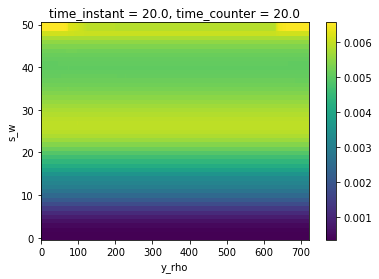

In [7]:
def N2Profile(run, strat, z, g=9.81):
    """
    Method to compute the N2 profile : 
    """   
    grid = run.ds['his'].attrs['xgcm-Grid']
    N2 = -g/run.params['rho0'] * grid.diff(strat,'s') / grid.diff(z,'s')
    ### s_w should be corrected (read in file), hence s_w(bottom)=-1, s_w(surface)=0
    Nz = N2.s_w.size
    
    N2 = N2.where(N2.s_w > 0, other=0)#.values = 0*N2.isel(s_w=1).values
    N2 = N2.where(N2.s_w < Nz-1, other=0)
    N2bot = N2.shift(s_w=-1).where(N2.s_w == 0, other=0)
    N2top = N2.shift(s_w=1).where(N2.s_w == Nz-1, other=0)
    N2 += N2bot + N2top
    #N2.loc[dict(s_w=Nz-1)].values = 0*N2.isel(s_w=-2).values
    return N2
    
z_rho = get_z(r, zeta=dsm.ssh_a, h=dsm.h, vgrid="r", hgrid="r")
Tmoy = z2zmoy(dsm.T_a, z_rho)
Tmoy = Tmoy.mean("x_rho").persist()
N2 = N2Profile(r,Tmoy,zmoy).chunk({"s_w":-1})
N2 = N2.assign_coords(z_w=zwoy).persist()

### some bricolage in case N2<0
Nmin = 1e-8
prov = N2.values<0
if (N2<=0).any():
    print("wow, I had to fix {0}/{1} negative values in N^2".format(prov.sum(),prov.size))
    N2 = N2.where(N2>Nmin, Nmin)

np.sqrt(N2).plot()

Text(0.5, 1.0, 't_cos x_avg/std')

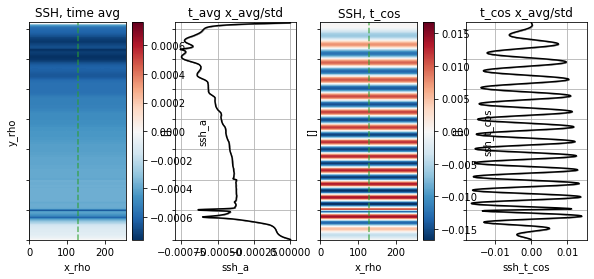

In [8]:
### Plot SSH: avg, t_cos, mean and std

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(10,4))
ax = axs[0]
r['his'].ssh_a.isel(time=indt).plot(ax=ax)
ax.axvline(indxm.start, color="grey")
ax.axvline(indxm.stop, color="grey")
ax.axvline(Nx//2, color="tab:green", linestyle="--", alpha=.7)
ax.set_title('SSH, time avg')

ax = axs[1]
hmoy = dsm.ssh_a.mean("x_rho")
hstd = dsm.ssh_a.std(dim="x_rho")
hmoy.plot(ax=ax, y="y_rho", color="k")
ax.fill_betweenx(dsm.y_rho, hmoy-hstd, hmoy+hstd, color="grey", alpha=.7)
ax.set_ylabel([])
ax.set_yticklabels([])
ax.grid(True)
ax.set_title('t_avg x_avg/std')

ax = axs[2]
r['his'].ssh_t_cos.isel(time=indt).plot(ax=ax)
ax.axvline(indxm.start, color="grey")
ax.axvline(indxm.stop, color="grey")
ax.axvline(Nx//2, color="tab:green", linestyle="--", alpha=.7)
ax.set_ylabel([])
ax.set_yticklabels([])
ax.set_title('SSH, time avg')
ax.set_title('SSH, t_cos')

ax = axs[3]
hmoy = dsm.ssh_t_cos.mean("x_rho")
hstd = dsm.ssh_t_cos.std(dim="x_rho")
hmoy.plot(ax=ax, y="y_rho", color="k")
ax.fill_betweenx(dsm.y_rho, hmoy-hstd, hmoy+hstd, color="grey", alpha=.7)
ax.set_ylabel([])
ax.set_yticklabels([])
ax.grid(True)
ax.set_title('t_cos x_avg/std')


## Compute vertical modes

<xarray.Dataset>
Dimensions:       (mode: 11, s_rho: 50, s_w: 51, y_rho: 722)
Coordinates:
    time_counter  float64 20.0
    eta_rho       (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
    xi_rho        (y_rho) float32 514000.0 514000.0 ... 514000.0 514000.0
    f             (y_rho) float32 0.00010309763 0.00010316237 ... 0.00014977805
  * mode          (mode) int64 0 1 2 3 4 5 6 7 8 9 10
    time_instant  float64 dask.array<chunksize=(), meta=np.ndarray>
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
    z_rho         (s_rho, y_rho) float64 dask.array<chunksize=(50, 722), meta=np.ndarray>
    z_w           (s_w, y_rho) float64 dask.array<chunksize=(51, 722), meta=np.ndarray>
Dimensions without coordinates: s_w, y_rho
Data variables:
    c             (mode, y_rho) float64 dask.array<chunksize=(11, 722), meta=np.ndarray>
    phi           (mode, s_rho, y_rho) float64 dask.array<chunksize=(11, 50, 722), meta=np.ndarray>
    dphidz      

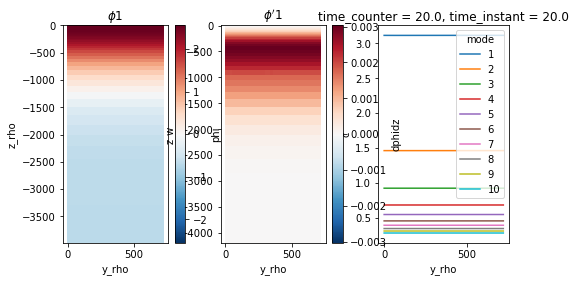

In [9]:
# compute mode on a y slice: that works fine
omega = r.params['omega']
dm = get_vmodes(zmoy, zwoy, N2, nmodes=10).persist()

fig, axs = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(8,4))
imod = 1
ax=axs[0]
dm.phi.sel(mode=imod).plot(x="y_rho", y="z_rho", ax=ax)
ax.set_title(r"$\phi $"+str(imod))
ax=axs[1]
dm.dphidz.sel(mode=imod).plot(x="y_rho", y="z_w", ax=ax)
ax.set_title(r"$\phi' $"+str(imod))
ax = axs[2]
dm.c.isel(mode=slice(1,None)).plot.line(x="y_rho", ax=ax)

dm

## Project dynamics on modes

Here grid breathing corrections are neglected and it is assumed that fields are given on mean grid 

Nomenclature:
* _c, _s are for cos, sin
* lowercase for wave, upper case (U, W, B) for mean flow
* p can be pressure or mode in long variable names

In [10]:
### Useful functions

grid = ds.attrs['xgcm-Grid']
dz = grid.diff(zwoy, "s")

def trapzw(data, zz):
    """ trapz for a function on w points (zz is also on w points)
    (b-a)*.5*(f(a)+f(b)) = sum(dz*grid.interp(f, "s"))"""
    return (grid.diff(zz, "s")*grid.interp(data, "s")).sum("s_rho")

def trapz(data, zz):
    """ wrapper of np.trapz. Does not work, everything crashes """
    if "s_w" in data.dims:
        indim = "s_w"
    elif "s_rho" in data.dims:
        indim = "s_rho"
    else:
        raise ValueError("core dim not found")
    #print("found core dim:", indim, data.dims, zz.dims)
    res = xr.apply_ufunc(np.trapz, data, zz, \
                dask='parallelized', input_core_dims = [[indim],[indim]], 
                output_dtypes=[np.float64], exclude_dims=set((indim,)))
    
def projp(data, zz, phin=dm.phi, dz=dz):
    """ projection on p-mode """
    prov = z2zmoy(data, zz)
    return (dz*prov*phin).sum("s_rho")/ds.h

### projection on w-mode. This is not very good for now
modw = grid.cumsum(dz*dm.phi, "s", to="outer", boundary="fill").chunk({"s_w":-1}).assign_coords(z_w=zwoy)

def projw(data, zz, phiw=modw, dz=dz, cn=dm.c): # not very cool
    """ using what I call "w-modes".
    for reconstructing, use w = wn*modw """
    prov = z2zmoy(data, zz)
    prov = (prov*zi_w2rho(phiw*N2, zwoy, zmoy)*dz).sum(dim="s_rho") \
            + grav* (phiw*grid.interp(prov, "s")).isel(s_w=-1)
    return prov/ds.h/cn**2

def projww(data, zz, phiw=modw, dz=dz, cn=dm.c): # not very cool
    """ using what I call "w-modes" and w data on w-points.
    for reconstructing, use w = wn*modw """
    prov = z2zwoy(data, zz)
    prov = (grid.interp(prov*phiw*N2, "s")*dz).sum(dim="s_rho") \
            + grav* (phiw*prov).isel(s_w=-1)
    return prov/ds.h/cn**2

def projwb(data, zz, phiw=modw, dz=dz, cn=dm.c): # not very cool
    """ using what I call "w-modes".
    for reconstructing, use w = wn*modw """
    prov = z2zwoy(data, zz)
    prov = (prov*phiw*N2).integrate(dim="s_w") \
            + grav* (phiw*prov).isel(s_w=-1)
    return prov/ds.h/cn**2

def projw_wb(data, zz, phib=dm.dphidz, dz=dz):
    """ this one is using varphi modes. You can verify that it does not change a lot 
    for reconstructing w, use -c^2/N^2*wn*dphidz """
    prov = z2zmoy(data, zz)
    prov = (prov*grid.interp(phib, "s")*dz).sum(dim="s_rho") \
            + grav* (phib/N2*grid.interp(prov, "s")).isel(s_w=-1)
    return -prov/ds.h

### projection of buoyancy. Works fine
def projb(data, zz, phib=dm.dphidz, dz=dz):
    """ N.B.: for reconstructing b, use -c**2*bn*dphidz """
    prov = z2zmoy(data, zz)
    prov = (prov*grid.interp(phib/N2, "s")*dz).sum("s_rho") \
            + grav* (grid.interp(prov, "s")*phib/N2**2).isel(s_w=-1)
    return -prov/ds.h #data.isel(s_rho=-1)

### others
def get_pres(grid,z,rho):
    """ compute pressure by integration from the surface, 
    taking rho at rho points and giving results on w points (z grid)
    with p=0 at the surface """
    _g = 9.81 # il faudrait arrêter de coder g en dur partout...
    dz = grid.diff(z, "s")
    return _g * grid.cumsum((rho*dz).sortby("s_rho",ascending=False), "s", \
                            to="outer", boundary="fill").sortby("s_w",ascending=False)


In [ ]:
prov = z2zwoy(ds.w_t_cos, z_rho).isel(x_rho=1)
## !!! I can plot prov.values but not prov.plot()

myint(prov, zwoy)

There is a problem here
Because of the interpolation from rho points to w points, I had to set core_dims in apply ufunc. However, when doing so, I obtain something weird:

In [11]:
### First interpolate w on the mean w-grid (from the "int" rho-grid):
z_rho = get_z(r, zeta=ds.ssh_a, h=ds.h, vgrid='r', hgrid='r').persist()

prov = z2zwoy(ds.w_t_cos, z_rho)

print("see: prov has the expected dimensions", prov.dims, prov.shape)

print("I need to multiply it by dphidz and N2, with dims", dm.dphidz.dims, N2.dims)

print("but it does not work")

print("for instance, for prov*N2, I have the dims", (prov*N2).dims)

print("but trying to read the values, I obtain this:")
(prov*N2).values

/home1/datahome/nlahaye/croco-si/crocosi/gridop.py:108: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(sc.dims[0], _zeta.dims[0], _zeta.dims[1])


see: prov has the expected dimensions ('y_rho', 'x_rho', 's_w') (722, 3, 51)
I need to multiply it by dphidz and N2, with dims ('mode', 's_w', 'y_rho') ('s_w', 'y_rho')
but it does not work
for instance, for prov*N2, I have the dims ('y_rho', 'x_rho', 's_w')
but trying to read the values, I obtain this:


ValueError: operands could not be broadcast together with shapes (51,3,1) (722,1,1) 

/home1/datahome/nlahaye/croco-si/crocosi/gridop.py:108: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(sc.dims[0], _zeta.dims[0], _zeta.dims[1])
/home1/datahome/nlahaye/croco-si/crocosi/gridop.py:108: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(sc.dims[0], _zeta.dims[0], _zeta.dims[1])


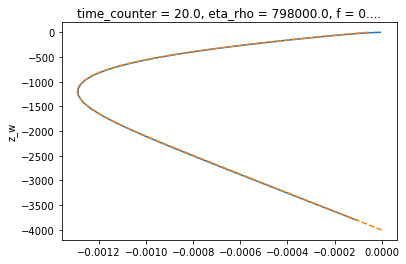

In [11]:
z_rho = get_z(r, zeta=ds.ssh_a, h=ds.h, vgrid='r', hgrid='r').persist()
z_w = get_z(r, zeta=ds.ssh_a, h=ds.h, vgrid='w', hgrid='r').persist()

wn_c = projw(ds.w_t_cos, z_rho).persist()
#wn_b = projwb(ds.w_t_cos, z_rho).persist()
bn_c = projb(ds.T_t_cos, z_rho).persist()

if True:
    ds.w_t_cos.assign_coords(z_r=z_rho).isel(x_rho=1,y_rho=200).plot(y="z_r")
    #wre = grid.interp(wn_c*modw, "s").assign_coords(z_r=zmoy).isel(x_rho=1, y_rho=200).sum("mode")
    #wre.plot(y="z_r",linestyle="--")
    wre = (wn_c*modw).assign_coords(z_w=zwoy).isel(x_rho=1, y_rho=200).sum("mode")
    wre.plot(y="z_w", linestyle="--")
else:
    ds.T_t_cos.isel(x_rho=0,y_rho=200).plot(y="s_rho")
    wre = grid.interp(-dm.c**2*bn_c*dm.dphidz, "s").isel(x_rho=0, y_rho=200).sum("mode")
    wre.plot(y="s_rho",linestyle="--")

#wbe = grid.interp(wn_b*modw, "s").isel(x_rho=0, y_rho=200).sum("mode")
#plt.plot(wbe.values, linestyle="--")

In [12]:
### Continuity equation
# N.B.: I don't know why I have to chunk after interp. Otherwise I have error
# e.g. " operands could not be broadcast together with shapes (50,722,1) (50,722) "

un_c = projp(grid.interp(ds.u_t_cos, "xi").chunk({"x_rho":-1}), z_rho).persist()
un_s = projp(grid.interp(ds.u_t_sin, "xi").chunk({"x_rho":-1}), z_rho).persist()

vn_c = projp(grid.interp(ds.v_t_cos, "eta").chunk({"y_rho":-1}), z_rho).persist()
vn_s = projp(grid.interp(ds.v_t_sin, "eta").chunk({"y_rho":-1}), z_rho).persist()

wn_c = projw(ds.w_t_cos, z_rho).persist()
wn_s = projw(ds.w_t_sin, z_rho).persist()

bn_c = projb(ds.T_t_cos, z_rho).persist()
bn_s = projb(ds.T_t_sin, z_rho).persist()

p_t_cos = zi_w2rho(get_pres(grid, z_w, ds.T_t_cos).chunk({"s_w":-1}), z_w, z_rho)/r.params['rho0'] + grav*ds.ssh_t_cos
p_t_sin = zi_w2rho(get_pres(grid, z_w, ds.T_t_sin).chunk({"s_w":-1}), z_w, z_rho)/r.params['rho0'] + grav*ds.ssh_t_sin

pn_c = projp(p_t_cos, z_rho).persist()
pn_s = projp(p_t_sin, z_rho).persist()


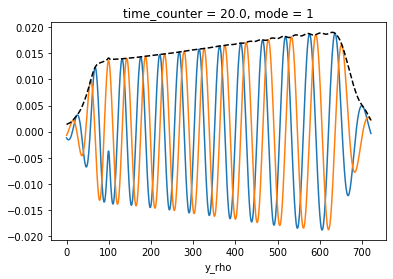

In [13]:
un_c.isel(x_rho=1, mode=1).plot()
un_s.isel(x_rho=1, mode=1).plot()
np.sqrt(un_s**2+un_c**2).isel(x_rho=1, mode=1).plot(linestyle="--", color="k")


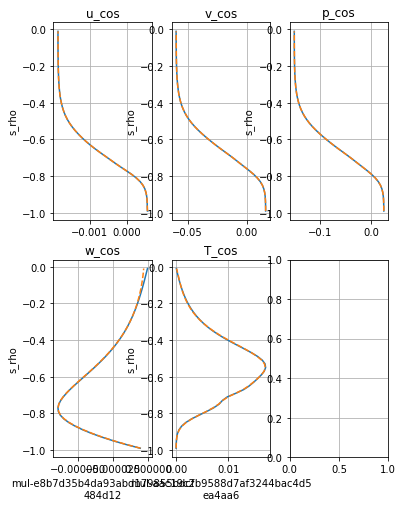

In [14]:
### test reconstruction 
# these look bad because they are plotted vs. s_rho, whereas actual z grid are different
# cf. previous exemple for the reconstruction of w

fig, axs = plt.subplots(2, 3, figsize=(6,8))
ix, jy = 0, 350

ax=axs[0,0]
grid.interp(ds.u_t_cos, "xi").isel(x_rho=ix,y_rho=jy).plot(y="s_rho", ax=ax)
(un_c*dm.phi).isel(x_rho=ix,y_rho=jy).sum("mode").plot(y="s_rho", linestyle="--", ax=ax)
ax.set_title('u_cos')

ax = axs[0, 1]
grid.interp(ds.v_t_cos, "eta").isel(x_rho=ix,y_rho=jy).plot(y="s_rho", ax=ax)
(vn_c*dm.phi).isel(x_rho=ix,y_rho=jy).sum("mode").plot(y="s_rho", linestyle="--", ax=ax)
ax.set_title('v_cos')

ax=axs[1,0]
ds.w_t_cos.isel(x_rho=ix,y_rho=jy).plot(y="s_rho", ax=ax)
grid.interp(wn_c*modw, "s").isel(x_rho=ix,y_rho=jy).sum("mode").plot(y="s_rho", 
                                                                linestyle="--", ax=ax)
ax.set_title('w_cos')

ax=axs[1,1]
ds.T_t_cos.isel(x_rho=ix,y_rho=jy).plot(y="s_rho", ax=ax)
grid.interp(-dm.c**2*bn_c*dm.dphidz, "s").isel(x_rho=ix,y_rho=jy).sum("mode").plot(\
                                                    y="s_rho", linestyle="--", ax=ax)
ax.set_title('T_cos')

ax = axs[0, 2]
p_t_cos.isel(x_rho=ix,y_rho=jy).plot(y="s_rho", ax=ax)
(pn_c*dm.phi).isel(x_rho=ix,y_rho=jy).sum("mode").plot(y="s_rho", linestyle="--", ax=ax)
ax.set_title('p_cos')

for ax in axs.ravel():
    ax.grid(True)

## compute $\int\phi_n\nabla\phi_m$
For cos component only so far
* pndxpm, pndypm: $\int\phi_n\partial_{x,y}\phi_m$, at rho points. I should be able to use "to=center" in grid but it does not work
* updxp, vpdyp: $u_n\int\phi_n\partial_x\phi_m$, $v_n\int\phi_n\partial_y\phi_m$.

In the present case, $x$-derivative of modes are zero by construction

In [15]:
### functions for derivative

if False:
    # first order differentiation
    def dxongrid(data):
        return grid.interp(grid.diff(data, "xi")/dx, "xi")
    def dyongrid(data):
        return grid.interp(grid.diff(data, "eta")/dy, "eta")
else:
    # centered finite difference, warning works only for homogeneous grid
    def dxongrid(data, docor=False, zr=None, zw=None, dx=dx):
        dxsig = data.chunk({"x_rho":-1}).differentiate("x_rho")
        if docor:
            dsig = grid.diff(data, "s") # rho, w
            hz = grid.diff(zw, "s") # rho, rho
            dxz = zr.chunk({"x_rho":-1}).differentiate("x_rho") # rho, rho
            lacor = grid.interp(dsig, "s")*hz*dxz
        else:
            lacor = 0
        return (dxsig - lacor)/dx
    
    def dyongrid(data, docor=False, zr=None, zw=None, dy=dy):
        dysig = data.chunk({"y_rho":-1}).differentiate("y_rho")
        if docor:
            dsig = grid.diff(data, "s") # w
            hz = grid.diff(zw, "s") # rho
            dyz = zr.chunk({"y_rho":-1}).differentiate("y_rho") # rho
            lacor = grid.interp(dsig, "s")*hz*dyz
        else:
            lacor = 0
        return (dysig - lacor)/dy

def dx_u2rho(data, docor=True, zr=None, zw=None, dx=dx):
        dxsig = grid.diff(data, "xi") # rho, rho
        if docor:
            dsig = grid.diff(data, "s") # u, w
            hz = grid.diff(zw, "s") # rho, rho
            dxz = grid.diff(zr, "xi") # u, rho
            lacor = grid.interp(grid.interp(dsig, "s")*dxz, "xi") / hz
        else:
            lacor = 0
        return (dxsig - lacor) / dx

def dy_v2rho(data, docor=True, zr=None, zw=None, dy=dy):
        dysig = grid.diff(data, "eta")
        if docor:
            dsig = grid.diff(data, "s") # u, w
            hz = grid.diff(zw, "s") # rho, rho
            dyz = grid.diff(zr, "eta") # u, rho
            lacor = grid.interp(grid.interp(dsig, "s")*dyz, "eta") / hz
        else:
            lacor = 0
        return (dysig - lacor) / dy

Text(0.5, 1.0, '$H^{-1}\\int\\phi_n\\nabla\\phi_m, n=$1 ($k=$2.31e-05)')

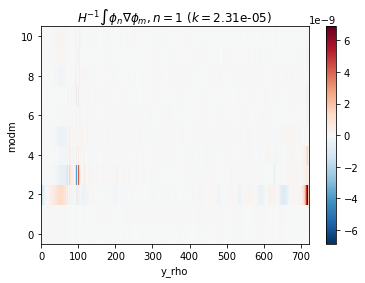

In [16]:
phin = dm.phi
phim = dm.phi.rename({"mode":"modm"})
dphim = dm.dphidz.rename({"mode":"modm"})

pndxpm = 0 #(phin * dxongrid(phim) * dz).sum("s_rho")/ds.h
### grid gradient
dpygrid = - grid.interp(dphim,"s") * dyongrid(zmoy)
pndypm = (phin * (dyongrid(phim)+dpygrid) * dz).sum("s_rho")/ds.h.mean("x_rho")

imode = 1
omega = 2*np.pi/(12*3600)
kn = np.sqrt(omega**2-ds.f.mean()**2)/dm.c.isel(mode=imode).mean()

pndypm.isel(mode=imode).plot(x="y_rho")
plt.gca().set_title(r'$H^{-1}\int\phi_n\nabla\phi_m, n=$'+str(imode)+r' ($k=$'+'{:.2e})'.format(kn.values))

Text(0, 0.5, '[day$^{-1}$]')

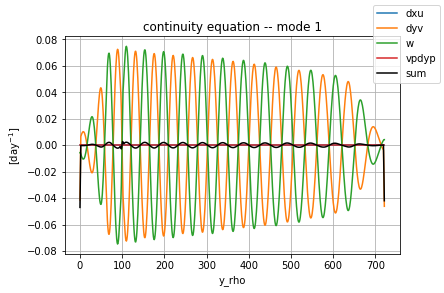

In [17]:
# check closure
imode = 1
fact = 24*3600 #(day-1)

dxu_cos = dxongrid(un_c).persist()
dyv_cos = dyongrid(vn_c).persist()
#updxp_cos = (un_c.rename({"mode":"modm"}) * pndxpm).sum("modm").persist()
vpdyp_cos = (vn_c.rename({"mode":"modm"}) * pndypm).sum("modm").persist()
updxp_cos = 0

fig = plt.figure()
ax = plt.subplot()
(dxu_cos.isel(mode=imode, x_rho=1)*fact).plot(label="dxu")
(dyv_cos.isel(mode=imode, x_rho=1)*fact).plot(label="dyv")
(wn_c.isel(mode=imode, x_rho=1)*fact).plot(label="w")
#updxp_cos.isel(mode=imode, x_rho=1).plot(label='updxp')
(vpdyp_cos.isel(mode=imode, x_rho=1)*fact).plot(label='vpdyp')

((dxu_cos+dyv_cos+wn_c+updxp_cos+vpdyp_cos).isel(mode=imode, x_rho=1)*fact)\
                .plot(color="k",label="sum")
fig.legend()
ax.set_title('continuity equation -- mode {0}'.format(imode))
ax.grid(True)
ax.set_ylabel(r'[day$^{-1}$]')

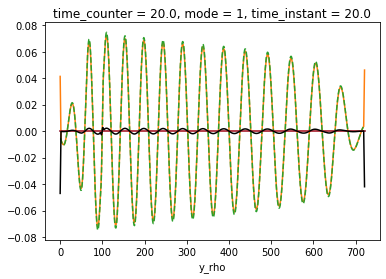

In [18]:
fig = plt.figure()
ax = plt.subplot()
(dxu_cos.isel(mode=imode, x_rho=1)*fact).plot(label="dxu")
(-dyv_cos.isel(mode=imode, x_rho=1)*fact).plot(label="dyv")
(wn_c.isel(mode=imode, x_rho=1)*fact).plot(label="w", linestyle="--")
#updxp_cos.isel(mode=imode, x_rho=1).plot(label='updxp')
(vpdyp_cos.isel(mode=imode, x_rho=1)*fact).plot(label='vpdyp')

((dxu_cos+dyv_cos+wn_c).isel(mode=imode, x_rho=1)*fact)\
                .plot(color="k",label="sum")

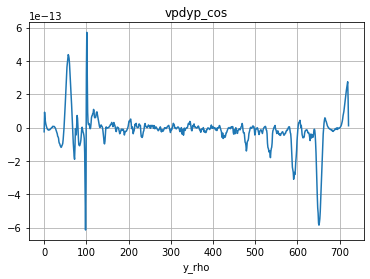

In [19]:
# updxp_cos.isel(mode=imode, x_rho=1).plot(label='updxp')
vpdyp_cos.isel(mode=imode, x_rho=1).plot(label='vpdyp')
plt.gca().set_title('vpdyp_cos')
plt.grid(True)

## Checking modal decomposition & continuity
In the end, vertical mode decomposition is valid for the total field, so we can just check what it gives on the total field (snapshot). Continuity equation is linear, so it makes it even easier. 

/home1/datahome/nlahaye/croco-si/crocosi/gridop.py:108: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(sc.dims[0], _zeta.dims[0], _zeta.dims[1])


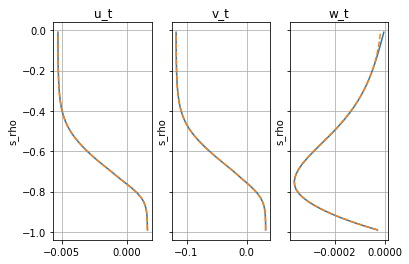

In [20]:
z_ri = get_z(r, zeta=ds.ssh_t_dirac, h=ds.h, vgrid='r', hgrid='r').persist()
un_t = projp(grid.interp(ds.u_t_dirac, "xi").chunk({"x_rho":-1}), z_ri).persist()
vn_t = projp(grid.interp(ds.v_t_dirac, "eta").chunk({"y_rho":-1}), z_ri).persist()
wn_t = projw(ds.w_t_dirac, z_ri).persist()

fig, axs = plt.subplots(1, 3, sharey=True)
ix, jy = 0, 350

ax = axs[0]
grid.interp(ds.u_t_dirac, "xi").isel(x_rho=ix,y_rho=jy).plot(y="s_rho", ax=ax)
ure = (un_t*dm.phi).isel(x_rho=ix,y_rho=jy).sum("mode")
ure.plot(y="s_rho",linestyle="--", ax=ax)
ax.set_title('u_t')

ax = axs[1]
grid.interp(ds.v_t_dirac, "eta").isel(x_rho=ix,y_rho=jy).plot(y="s_rho", ax=ax)
vre = (vn_t*dm.phi).isel(x_rho=ix,y_rho=jy).sum("mode")
vre.plot(y="s_rho",linestyle="--", ax=ax)
ax.set_title('v_t')

ax = axs[2]
ds.w_t_dirac.isel(x_rho=ix,y_rho=jy).plot(y="s_rho", ax=ax)
wre = zi_w2rho(wn_t*modw, zwoy,zmoy).isel(x_rho=ix,y_rho=jy).sum("mode")
wre.plot(y="s_rho",linestyle="--", ax=ax)
ax.set_title('w_t')

for ax in axs:
    ax.grid(True)

Text(0, 0.5, '[day$^{-1}$]')

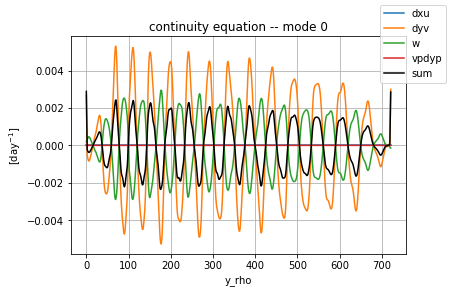

In [21]:
imode = 0

dxu_t = dxongrid(un_t).persist()
dyv_t = dyongrid(vn_t).persist()
vpdyp_t = (vn_t.rename({"mode":"modm"}) * pndypm).sum("modm").persist()
updxp_t = 0

fig = plt.figure()
ax = plt.subplot()
(dxu_t.isel(mode=imode, x_rho=1)*fact).plot(label="dxu")
(dyv_t.isel(mode=imode, x_rho=1)*fact).plot(label="dyv")
(wn_t.isel(mode=imode, x_rho=1)*fact).plot(label="w")
#updxp_t.isel(mode=imode, x_rho=1).plot(label='updxp')
(vpdyp_t.isel(mode=imode, x_rho=1)*fact).plot(label='vpdyp')
res_cent = (dxu_t+dyv_t+wn_t+updxp_t+vpdyp_t).isel(mode=imode, x_rho=1)
(res_cent*fact).plot(color="k",label="sum")

fig.legend()
ax.set_title('continuity equation -- mode {0}'.format(imode))
ax.grid(True)
ax.set_ylabel(r'[day$^{-1}$]')

Text(0, 0.5, '[day$^{-1}$]')

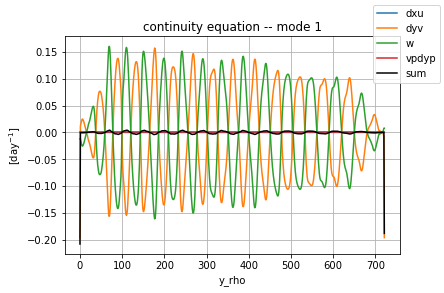

In [22]:
### What if I project u, v on the scattered grid?
# N.B.: no need to interp modes and mean z on x here, thinks it's mean
# N.B.2: still errors: the x/eta interp are on sigma levels, not z levels...
# I could add the correction but I think it won't be major

def proju(data, zz, phin=dm.phi, dz=dz):
    """ projection on p-mode """
    prov = z2zmoy(data, zz)
    return (dz*prov*phin).sum("s_rho")/grid.interp(ds.h, "xi")
                  
def projv(data, zz, phin=grid.interp(dm.phi, "eta"), dz=grid.interp(dz, "eta")):
    """ projection on p-mode """
    prov = z2zmoy(data, zz, zmoy=grid.interp(zmoy, "eta"))
    return (dz*prov*phin).sum("s_rho")/grid.interp(ds.h, "eta")
                  
un_d = proju(ds.u_t_dirac.chunk({"s_rho":-1}), grid.interp(z_ri, "xi")).persist()
vn_d = projv(ds.v_t_dirac.chunk({"s_rho":-1}), grid.interp(z_ri, "eta")).persist()

imode = 1
dxu_d = grid.diff(un_d, "xi").persist()/dx
dyv_d = grid.diff(vn_d, "eta").persist()/dy
vpdyp_d = (grid.interp(vn_d, "eta").rename({"mode":"modm"}) * pndypm).sum("modm").persist()
updxp_d = 0

fig = plt.figure()
ax = plt.subplot()
(dxu_d.isel(mode=imode, x_rho=1)*fact).plot(label="dxu")
(dyv_d.isel(mode=imode, x_rho=1)*fact).plot(label="dyv")
(wn_t.isel(mode=imode, x_rho=1)*fact).plot(label="w")
#updxp_t.isel(mode=imode, x_rho=1).plot(label='updxp')
(vpdyp_d.isel(mode=imode, x_rho=1)*fact).plot(label='vpdyp')
res_stag = (dxu_d+dyv_d+wn_t+updxp_d+vpdyp_d).isel(mode=imode, x_rho=1)
(res_stag*fact).plot(color="k",label="sum")

fig.legend()
ax.set_title('continuity equation -- mode {0}'.format(imode))
ax.grid(True)
ax.set_ylabel(r'[day$^{-1}$]')

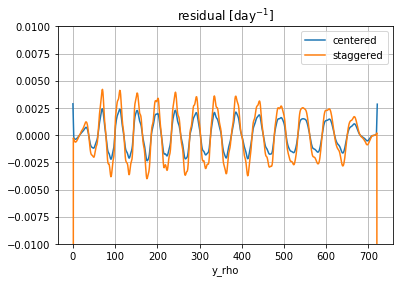

In [23]:
### compare both ways (finite diff vs. finite volume approach)
# So, it must be w that is the problem.

fig = plt.figure()
(res_cent*fact).plot(label="centered")
(res_stag*fact).plot(label="staggered")
plt.title(r'residual [day$^{-1}$]')
plt.ylim([-.01, .01])
plt.legend()
plt.grid(True)

/home1/datahome/nlahaye/croco-si/crocosi/gridop.py:108: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(sc.dims[0], _zeta.dims[0], _zeta.dims[1])
/home1/datahome/nlahaye/croco-si/crocosi/gridop.py:108: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(sc.dims[0], _zeta.dims[0], _zeta.dims[1])


Text(0.5, 1.0, 'continuity eq., model')

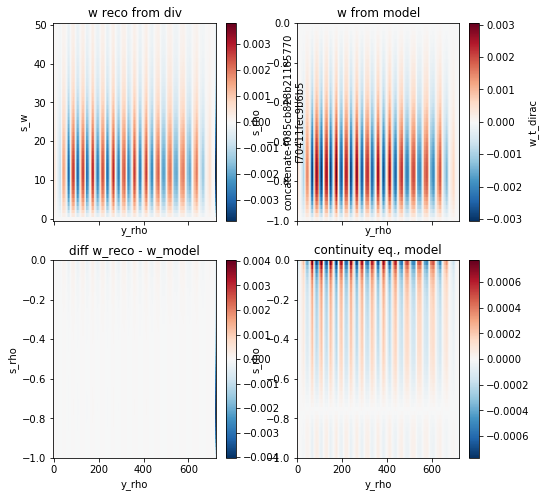

In [24]:
### check that w is w
z_wi = get_z(r, zeta=ds.ssh_t_dirac, h=ds.h, vgrid='w', hgrid='r').persist()
z_ri = get_z(r, zeta=ds.ssh_t_dirac, h=ds.h, vgrid='r', hgrid='r').persist()
dzi = grid.diff(z_wi, "s").isel(x_rho=1)
dxu = dx_u2rho(ds.u_t_dirac, docor=True, zr=z_ri, zw=z_wi).isel(x_rho=1)
dyv = dy_v2rho(ds.v_t_dirac, docor=True, zr=z_ri, zw=z_wi).isel(x_rho=1)

wre = -grid.cumsum((dxu+dyv)*dzi, "s", to="outer", boundary="fill")

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(8,8))
wre.plot(ax=axs[0,0])
axs[0,0].set_title('w reco from div')
ds.w_t_dirac.isel(x_rho=1).plot(ax=axs[0,1])
axs[0,1].set_title("w from model")
(zi_w2rho(wre, z_wi,z_ri)-ds.w_t_dirac).isel(x_rho=1).plot(ax=axs[1,0])
axs[1,0].set_title("diff w_reco - w_model")
### now check that continuity closes when computed offline
#dzw = (grid.diff(wre, "s")/dzi)#.isel(x_rho=1)
# Note that centered difference is wrong here
dzw = ds.w_t_dirac.chunk({"s_rho":-1}).differentiate("s_rho").isel(x_rho=1)/dzi
(dxu+dyv+dzw).plot(ax=axs[1,1])
axs[1,1].set_title("continuity eq., model")


This shows that there are some differences between the offline and online vertical velocities. 

So, if I try to project the equation using the reconstructed w -> that's not better (see below). Which means that the modal projection is the problem (maybe because of w)


/home1/datahome/nlahaye/croco-si/crocosi/gridop.py:108: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(sc.dims[0], _zeta.dims[0], _zeta.dims[1])
/home1/datahome/nlahaye/croco-si/crocosi/gridop.py:108: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(sc.dims[0], _zeta.dims[0], _zeta.dims[1])


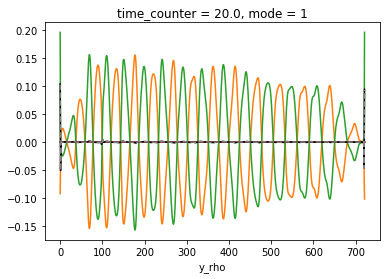

In [82]:
### So, if I try to project the equation using the reconstructed w
# evaluate previous cell before this one
z_wi = get_z(r, zeta=ds.ssh_t_dirac, h=ds.h, vgrid='w', hgrid='r').persist()
z_ri = get_z(r, zeta=ds.ssh_t_dirac, h=ds.h, vgrid='r', hgrid='r').persist()
dzi = grid.diff(z_wi, "s").persist()
dxu = dx_u2rho(ds.u_t_dirac, docor=True, zr=z_ri, zw=z_wi).persist()
dyv = dy_v2rho(ds.v_t_dirac, docor=True, zr=z_ri, zw=z_wi).persist()

wre = -grid.cumsum((dxu+dyv)*dzi, "s", to="outer", boundary="fill").chunk({"s_w":-1,"y_rho":-1,"x_rho":-1})
wn_re = projww(wre, z_wi)
wn_be = projw(grid.interp(wre, "s"), z_ri)

imode = 1
(dxu_t.isel(mode=imode, x_rho=1)*fact).plot(label="dxu")
(dyv_t.isel(mode=imode, x_rho=1)*fact).plot(label="dyv")
(wn_re.isel(mode=imode, x_rho=1)*fact).plot(label="w")
#updxp_t.isel(mode=imode, x_rho=1).plot(label='updxp')
(vpdyp_t.isel(mode=imode, x_rho=1)*fact).plot(label='vpdyp')

((dxu_t+dyv_t+wn_re+updxp_t+vpdyp_t).isel(mode=imode, x_rho=1)*fact)\
                .plot(color="k",label="sum")
((dxu_t+dyv_t+wn_be+updxp_t+vpdyp_t).isel(mode=imode, x_rho=1)*fact)\
                .plot(color="gray",label="sum", linestyle="--")

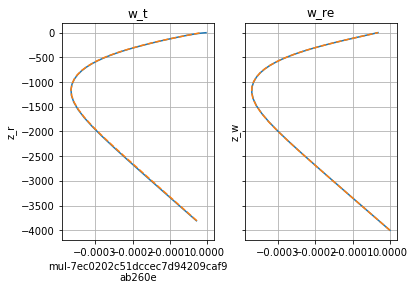

In [83]:
### compare projection of w reconstructed at w points and w model at rho points
## must run previous cell before

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
ax = axs[0]
ds.w_t_dirac.assign_coords(z_r=z_ri).isel(x_rho=ix,y_rho=jy).plot(y="z_r", ax=ax)
wb = grid.interp(wn_t*modw, "s").assign_coords(z_r=zmoy).isel(x_rho=ix,y_rho=jy).sum("mode")
wb.plot(y="z_r",linestyle="--", ax=ax)
ax.set_title('w_t')

ax = axs[1]
wre.assign_coords(z_w=z_wi).isel(x_rho=ix,y_rho=jy).plot(y="z_w", ax=ax)
wb = (wn_re*modw).assign_coords(z_w=zwoy).isel(x_rho=ix,y_rho=jy).sum("mode")
wb.plot(y="z_w",linestyle="--", ax=ax)
ax.set_title('w_re')

for ax in axs:
    ax.grid(True)

## Other equations
momentum and pressure. 
Back to sin/cos decomposition, WARNING rerun corresponding cells before

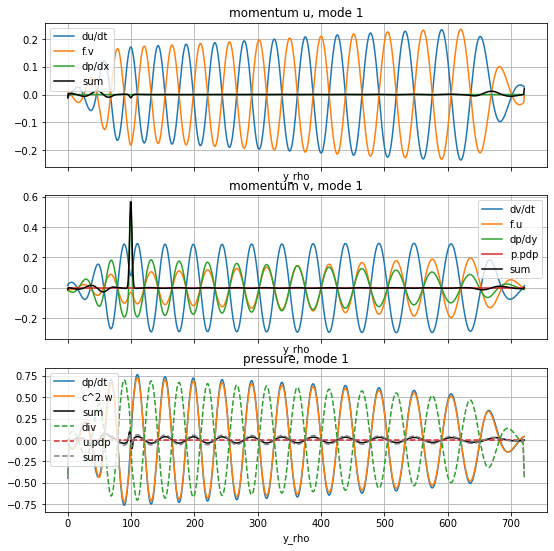

In [26]:
omega = r.params['omega']
### FIXING --- replace fbis by ds.f and remove the following line when f is fixed in datasets
fbis = ds.attrs['f0'] + (ds.eta_rho-ds.eta_rho.isel(y_rho=722//2))*ds.attrs["beta"]

# du/dt is omega*sin for cos, -omega*cos for sin
dxu_cos = dxongrid(un_c).persist()
dyv_cos = dyongrid(vn_c).persist()
dxp_cos = dxongrid(pn_c).persist()
dyp_cos = dyongrid(pn_c).persist()
ppdxp_cos = (pn_c.rename({"mode":"modm"}) * pndxpm).sum("modm").persist()
ppdyp_cos = (pn_c.rename({"mode":"modm"}) * pndypm).sum("modm").persist()
updxp_cos = (un_c.rename({"mode":"modm"}) * pndxpm).sum("modm").persist()
vpdxp_cos = (vn_c.rename({"mode":"modm"}) * pndxpm).sum("modm").persist()

imode = 1
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(9,9))

ax = axs[0]
(omega*un_s.isel(mode=imode, x_rho=1)*fact).plot(label="du/dt", ax=ax)
((-fbis*vn_c).isel(mode=imode, x_rho=1)*fact).plot(label="f.v", ax=ax)
(dxp_cos.isel(mode=imode, x_rho=1)*fact).plot(label="dp/dx", ax=ax)
#(ppdxp_cos.isel(mode=imode, x_rho=1)*fact).plot(label="p.pdp", ax=ax)
((omega*un_s - fbis*vn_c + dxp_cos + ppdxp_cos).isel(mode=imode, x_rho=1)*fact)\
                .plot(color="k",label="sum", ax=ax)
#((omega*un_s - ds.f*vn_c + dxp_cos + ppdxp_cos).isel(mode=imode, x_rho=1)*fact)\
#                .plot(color="k",label="sum", ax=ax)
ax.set_title('momentum u, mode {0}'.format(imode))

ax = axs[1]
(omega*vn_s.isel(mode=imode, x_rho=1)*fact).plot(label="dv/dt", ax=ax)
((fbis*un_c).isel(mode=imode, x_rho=1)*fact).plot(label="f.u", ax=ax)
(dyp_cos.isel(mode=imode, x_rho=1)*fact).plot(label="dp/dy", ax=ax)
(ppdyp_cos.isel(mode=imode, x_rho=1)*fact).plot(label="p.pdp", ax=ax)

((omega*vn_s + fbis*un_c + dyp_cos + ppdyp_cos).isel(mode=imode, x_rho=1)*fact)\
                .plot(color="k",label="sum", ax=ax)    
ax.set_title('momentum v, mode {0}'.format(imode))

ax = axs[2]
(omega*pn_s.isel(mode=imode, x_rho=1)*fact).plot(label="dp/dt", ax=ax)
((dm.c**2*wn_c).isel(mode=imode, x_rho=1)*fact).plot(label="c^2.w", ax=ax)

((omega*pn_s - dm.c**2*wn_c).isel(mode=imode, x_rho=1)*fact)\
                .plot(color="k",label="sum", ax=ax)    
### with continuity equation instead of w
wconta, wcontb = -(dxu_cos+dyv_cos), -(updxp_cos+vpdyp_cos)
((-dm.c**2*wconta).isel(mode=imode, x_rho=1)*fact).plot(\
                    label="div", linestyle="--", ax=ax)
((-dm.c**2*wcontb).isel(mode=imode, x_rho=1)*fact).plot(\
                    label="u.pdp", linestyle="--", ax=ax)
((omega*pn_s - dm.c**2*(wconta+wcontb)).isel(mode=imode, x_rho=1)*fact)\
                .plot(color="grey",linestyle="--", label="sum", ax=ax) 
ax.set_title('pressure, mode {0}'.format(imode))

for ax in axs:
    ax.legend()
    ax.grid(True)
    

In [174]:
fig.savefig('white_run_closure.pdf', magnification="auto", bbox_inches="tight")

## Now using swaths
Also checking continuity with omega variable

In [7]:
r = pp.CROCOrun(root_path+run, prefix='file_', open_nc=["swath"], grid_params=gparams, verbose=True)

ds = r["swath"]
 
indt = 20*48

ds = ds.isel(time=indt)

Analysing directory /home/datawork-lops-osi/equinox/jetn/jet_cfg1_wp0_noperturb_0a100j_floats_lev50_itide/
Found 1 segments
Found 5 his files
Found 10 swath files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected y_itide = 400000.0 m
Detected jet_ywidth = 800000.0 m
Detected jet_weight = 0.0
Detected omega = 0.000145444104333 1/s
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['his', 'swath']
Grid size: (L ,M, N) = (258, 722, 50)
